In [65]:
import pandas as pd

import torch.nn as nn
import torch

import copy
import re
import networkx as nx
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import os
import numpy as np

import seaborn as sns

In [84]:
class PimaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8, 32)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(32, 64)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(64, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x
    
    
def load_model():
    model = torch.load('model_training/model')
    model.eval()
    return model

def eval_model(model, input):
    # print(input)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0]


def load_data(data):
    return np.load(data)

def apply_phenotype(array, phenotype):
    # Split the phenotype string into individual operations
    operations = phenotype.split(';')
    x = copy.deepcopy(array)
    # Iterate over each operation and execute it
    for operation in operations:
        # Strip any leading/trailing whitespace from the operation
        operation = operation.strip()
        
        # Use the exec function to execute the operation on the array
        if operation:
            exec(operation)

    return x

def combine_operations(phenotype, original_input):
    combined_operations = []
    processed_input = apply_phenotype(original_input, phenotype)
    change =  processed_input - original_input
    
    # print(change)
    for i, j  in enumerate(change):
        if j == 0:
            continue
        else:
            if j > 0:
                combined_operations.append(f'x[{i}] += {j}')
            else:
                combined_operations.append(f'x[{i}] -= {-j}')
                
    return '; '.join(combined_operations)

def permute_phenotype(phenotype):
    
    split_phenotype = [i.strip() for i in phenotype.split(";")]
    if len(split_phenotype) == 1:
        return None
    permute_dict = {}
    for i, j in enumerate(split_phenotype):
        split_phenotype_copy = copy.deepcopy(split_phenotype)
        key_string = split_phenotype_copy.pop(i)
        key = key_string.split(" ")[0][2]
        permute_dict[key] = '; '.join(split_phenotype_copy)
    return permute_dict


def eval_phenotype(model, input):
    with torch.no_grad():
        prob = model(input)
        # print(prob.tolist()[0])
    if prob.tolist()[0] > 0.5:
        return 1
    else:
        return 0


def perturbation_effect(phenotype_list, model, input, features_index):
    """
    number of failure signifies that how many times  after removing the feature, the
    phenotype still worked 
    """
    
    num_failure = {str(i) : 0 for i in range(features_index)}
    total = {str(i) : 0 for i in range(features_index)}
    for phenotype in phenotype_list:
        modified_input  = apply_phenotype(input, phenotype)
        phenotype_output_model = eval_model(model, torch.tensor(modified_input, dtype=torch.float32))
        if phenotype_output_model < 0.5:
            continue
        permute_dict = permute_phenotype(phenotype)
        if permute_dict is not None:
            # print(permute_dict)
            for key, value in permute_dict.items():
                input_evolved =  apply_phenotype(input, value)
                total[key] += 1
                num_failure[key] += eval_phenotype(model, torch.tensor(input_evolved, dtype=torch.float32))
    return num_failure, total
                

def phenotype_perturbation_analysis(input_folder, features, model, features_index=8):
    permutation_result = {}
    for i in os.listdir(input_folder):
        if i=='.DS_Store':
            continue
        filename = input_folder + '/' + i + '/' "final_gen.csv"
        input_array_location = input_folder + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        model_out = eval_model(model, torch.tensor(input, dtype=torch.float32))
        data = pd.read_csv(filename)
        data = data.sort_values(by=['o_1'])
        # data = data[data['o_1'] < 0.45]
        data['combined_phenotype'] = data.apply(lambda row: combine_operations(row['Phenotype'], input), axis=1)
        num_failure, total = perturbation_effect(list(data['combined_phenotype']), model, input, features_index)
        permutation_result[i] = (num_failure, total)
    return permutation_result
        


In [85]:
model = load_model()
input_folder = 'output/NSGAIII'
features = ["Pregnancies",'Glucose','Blood Pressure','Skin Thickness','Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']
permutation_result = phenotype_perturbation_analysis(input_folder, features, model, features_index=8)

In [100]:
def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def add_dict_values(dict1, dict2):
    if dict1.keys() != dict2.keys():
        raise ValueError("Both dictionaries must have the same keys")

    result_dict = {}

    for key in dict1:
        result_dict[key] = dict1[key] + dict2[key]

    return result_dict


success_dict = {str(i) : 0 for i in range(8)}
total_dict = {str(i) : 0 for i in range(8)}
for key, value in permutation_result.items():
    success_dict  =  add_dict_values(success_dict, value[0])
    total_dict  =  add_dict_values(total_dict, value[1])

In [97]:
success_dict, total_dict

({'0': 304,
  '1': 219,
  '2': 171,
  '3': 123,
  '4': 91,
  '5': 104,
  '6': 139,
  '7': 168},
 {'0': 347,
  '1': 417,
  '2': 527,
  '3': 170,
  '4': 128,
  '5': 132,
  '6': 142,
  '7': 705})

In [103]:
# percentage time the counterfactual fails if the feature change is removed.
features = ["Pregnancies",'Glucose','Blood Pressure','Skin Thickness','Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']
percentage_dict = {}
percentage_dict_with_features = {}
for key, value in total_dict.items():
    percentage_dict[key] = 100 - success_dict[key]/total_dict[key] * 100
    percentage_dict_with_features[features[int(key)]] = 100 - success_dict[key]/total_dict[key] * 100
percentage_dict, percentage_dict_with_features

({'0': 12.391930835734868,
  '1': 47.48201438848921,
  '2': 67.55218216318787,
  '3': 27.64705882352942,
  '4': 28.90625,
  '5': 21.212121212121218,
  '6': 2.1126760563380316,
  '7': 76.17021276595744},
 {'Pregnancies': 12.391930835734868,
  'Glucose': 47.48201438848921,
  'Blood Pressure': 67.55218216318787,
  'Skin Thickness': 27.64705882352942,
  'Insulin': 28.90625,
  'BMI': 21.212121212121218,
  'DiabetesPedigreeFunction': 2.1126760563380316,
  'Age': 76.17021276595744})

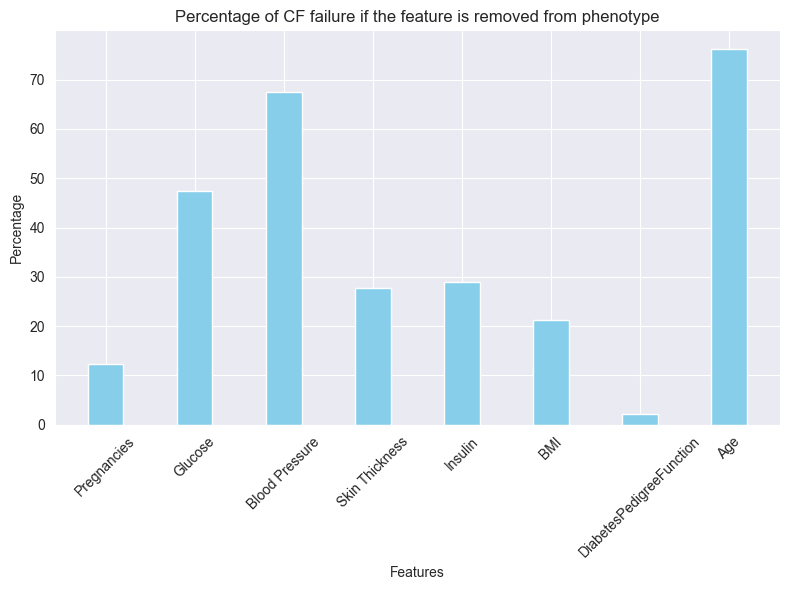

In [104]:
plot_bar_graph(percentage_dict_with_features, title="Percentage of CF failure if the feature is removed from phenotype", xlabel="Features", ylabel="Percentage")